In [ ]:
# this is mainly from a chatgpt session: https://chatgpt.com/share/675f3201-3704-8000-a34d-ce16e4a905f7

bad stats line ['ERR1653160.contigs.from_fixed_contigs.redo_links.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['ERR1653160.contigs.from_fixed_contigs.redo_links.noec.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['ERR1653160.contigs.from_fixed_contigs.no_redo_links.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['SRR2032467.contigs.from_fixed_contigs.no_redo_links.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['SRR2032467.contigs.from_fixed_contigs.redo_links.noec.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['SRR2032467.contigs.from_fixed_contigs.redo_links.fa', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
bad stats line ['SRR23346373.contigs.from_fixed_contigs.no_redo_links.fa', '0'

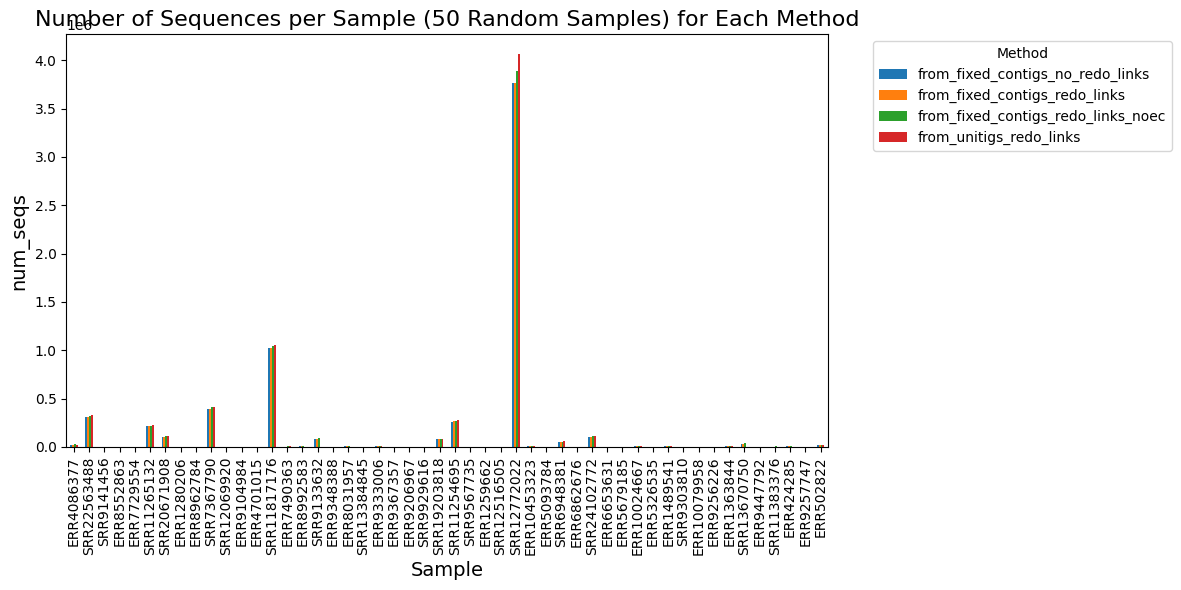

In [3]:
import glob
import pandas as pd

# Step 2: Parse all the log files
log_files = glob.glob("stats/*/*.fa.log.txt", recursive=True)

records = []

for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()
    
    # Find the index of the header line that starts with "file"
    header_index = None
    for i, line in enumerate(lines):
        if line.startswith("file"):
            header_index = i
            break
    
    if header_index is not None and header_index + 1 < len(lines):
        # The next line after header is the data line
        data_line = lines[header_index + 1]
        parts = data_line.split()
        # Example line (fields):
        # file format type num_seqs sum_len min_len avg_len max_len Q1 Q2 Q3 sum_gap N50 N50_num Q20(%) Q30(%) AvgQual GC(%) sum_n
        # indices: 
        # 0:file_name 
        # 1:format 
        # 2:type 
        # 3:num_seqs 
        # 4:sum_len 
        # 5:min_len 
        # 6:avg_len 
        # 7:max_len 
        # 8:Q1 
        # 9:Q2 
        # 10:Q3 
        # 11:sum_gap 
        # 12:N50 
        # 13:N50_num 
        # 14:Q20(%) 
        # 15:Q30(%) 
        # 16:AvgQual 
        # 17:GC(%) 
        # 18:sum_n

        filename = parts[0]
        sample = filename.split(".")[0]
        
        # A helper function to convert a string to int after removing commas
        def to_int(x):
            return int(x.replace(',', ''))

        # A helper function to convert a string to float after removing commas
        def to_float(x):
            return float(x.replace(',', ''))

        # Identify method
        if "from_fixed_contigs.no_redo_links" in filename:
            method = "from_fixed_contigs_no_redo_links"
        elif "from_fixed_contigs.redo_links.fa" in filename:
            method = "from_fixed_contigs_redo_links"
        elif "from_fixed_contigs.redo_links.noec.fa" in filename:
            method = "from_fixed_contigs_redo_links_noec"
        elif "from_unitigs.redo_links" in filename:
            method = "from_unitigs_redo_links"
        else:
            method = "unknown"
            
        if len(parts) < 19:
            print("bad stats line",parts)
            continue

        record = {
            'sample': sample,
            'method': method,
            'num_seqs': to_int(parts[3]),
            'sum_len': to_int(parts[4]),
            'min_len': to_int(parts[5]),
            'avg_len': to_float(parts[6]),
            'max_len': to_int(parts[7]),
            'Q1': to_float(parts[8]),
            'Q2': to_float(parts[9]),
            'Q3': to_float(parts[10]),
            'sum_gap': to_int(parts[11]),
            'N50': to_int(parts[12]),
            'N50_num': to_int(parts[13]),
            'Q20(%)': to_float(parts[14]),
            'Q30(%)': to_float(parts[15]),
            'AvgQual': to_float(parts[16]),
            'GC(%)': to_float(parts[17]),
            'sum_n': to_int(parts[18])
        }

        records.append(record)

# Step 3: Create a DataFrame and pivot it
df = pd.DataFrame(records)
df_pivot = df.pivot(index='sample', columns='method', values=[
    'num_seqs','sum_len','min_len','avg_len','max_len',
    'Q1','Q2','Q3','sum_gap','N50','N50_num','Q20(%)','Q30(%)','AvgQual','GC(%)','sum_n'
])

import matplotlib.pyplot as plt

# Extract just the 'num_seqs' data
num_seqs_data = df_pivot['num_seqs']

# Randomly sample 50 accessions (samples) for plotting
subset = num_seqs_data.sample(n=50, random_state=42)

# Create the grouped bar plot for the subset
ax = subset.plot(kind='bar', figsize=(12,6))
ax.set_title('Number of Sequences per Sample (50 Random Samples) for Each Method', fontsize=16)
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('num_seqs', fontsize=14)

# Move legend outside the plot
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
# Convert the pivoted DataFrame to a "long" format so each method is on its own line
df_long = df_pivot.stack(level='method').reset_index()

# Rename columns for clarity
df_long.rename(columns={'level_1': 'method'}, inplace=True)

# Now df_long has columns: ['sample', 'method', 'num_seqs', 'sum_len', 'min_len', ...]
# and each row corresponds to one method for one accession

# Sort by sample and then by method if needed
df_long.sort_values(by=['sample', 'method'], inplace=True)

# Print the resulting table
print(df_long.to_string(index=False))

     sample                             method   num_seqs      sum_len  min_len  avg_len  max_len      Q1      Q2      Q3  sum_gap      N50  N50_num  Q20(%)  Q30(%)  AvgQual  GC(%)  sum_n
  DRR000001   from_fixed_contigs_no_redo_links      877.0    3999298.0     31.0   4560.2  49841.0    81.0   665.0  5950.0      0.0  14977.0     85.0     0.0     0.0      0.0  43.46    0.0
  DRR000001      from_fixed_contigs_redo_links      877.0    3999298.0     31.0   4560.2  49841.0    81.0   665.0  5950.0      0.0  14977.0     85.0     0.0     0.0      0.0  43.46    0.0
  DRR000001 from_fixed_contigs_redo_links_noec      877.0    3999298.0     31.0   4560.2  49841.0    81.0   665.0  5950.0      0.0  14977.0     85.0     0.0     0.0      0.0  43.46    0.0
  DRR000001            from_unitigs_redo_links      882.0    3999502.0     31.0   4534.6  49841.0    79.0   652.0  5931.0      0.0  14977.0     85.0     0.0     0.0      0.0  43.46    0.0
  DRR000002   from_fixed_contigs_no_redo_links      923.0   

In [5]:
# print samples that differ

no_redo_df = df_pivot.xs('from_fixed_contigs_no_redo_links', level=1, axis=1)
redo_df = df_pivot.xs('from_fixed_contigs_redo_links', level=1, axis=1)

# Check differences
diff = no_redo_df != redo_df

# Identify samples where there is at least one difference in any metric
samples_with_diff = diff.any(axis=1)

# Print samples that differ
if samples_with_diff.any():
    print("Samples with at least one differing metric between no_redo_links and redo_links:")
    print(samples_with_diff[samples_with_diff].index.tolist())
else:
    print("No differences found between from_fixed_contigs_no_redo_links and from_fixed_contigs_redo_links.")


Samples with at least one differing metric between no_redo_links and redo_links:
['DRR000003', 'DRR000005', 'DRR030840', 'DRR031084', 'DRR087302', 'DRR126186', 'DRR176104', 'DRR176417', 'DRR196679', 'DRR376537', 'DRR483512', 'ERR031965', 'ERR044084', 'ERR10018474', 'ERR10021034', 'ERR10030392', 'ERR10046838', 'ERR10103094', 'ERR1014678', 'ERR1016602', 'ERR1024612', 'ERR10365108', 'ERR10380914', 'ERR10425310', 'ERR10446643', 'ERR1044772', 'ERR10453323', 'ERR10463872', 'ERR10474964', 'ERR10512749', 'ERR1067154', 'ERR10676602', 'ERR10707817', 'ERR10740557', 'ERR10741887', 'ERR10758770', 'ERR10759270', 'ERR10771031', 'ERR10852410', 'ERR10864448', 'ERR10888572', 'ERR1088999', 'ERR1089592', 'ERR10937587', 'ERR10984373', 'ERR11256962', 'ERR11260186', 'ERR11261413', 'ERR11280817', 'ERR11472564', 'ERR114763', 'ERR1162795', 'ERR11652578', 'ERR11662954', 'ERR11663537', 'ERR11663716', 'ERR11664059', 'ERR11686599', 'ERR11782682', 'ERR1202960', 'ERR12038199', 'ERR1235223', 'ERR1236299', 'ERR1236310'

In [6]:
# find sample with largest absolute diff
no_redo_df = df_pivot.xs('from_fixed_contigs_no_redo_links', level=1, axis=1)
redo_df = df_pivot.xs('from_fixed_contigs_redo_links', level=1, axis=1)

sum_len_diff = redo_df['sum_len'] - no_redo_df['sum_len']
max_diff_sample = sum_len_diff.abs().idxmax()
max_diff_value = sum_len_diff.loc[max_diff_sample]

print(f"Sample with the biggest difference in sum_len: {max_diff_sample}")
print(f"Difference in sum_len: {max_diff_value}")

# Optionally, show the actual values for this sample from both methods
print("\nFrom fixed_contigs_no_redo_links:")
print(no_redo_df.loc[max_diff_sample, 'sum_len'])
print("From fixed_contigs_redo_links:")
print(redo_df.loc[max_diff_sample, 'sum_len'])


Sample with the biggest difference in sum_len: SRR12886701
Difference in sum_len: 1819372.0

From fixed_contigs_no_redo_links:
677278336.0
From fixed_contigs_redo_links:
679097708.0


In [7]:
# load original contigs stats
import pandas as pd
import pyarrow.dataset as ds
import s3fs

# Replace with your S3 bucket URL
s3_parquet_url = "s3://logan-pub/stats/logan-seqstats.parquet"

# Create an S3 filesystem instance
fs = s3fs.S3FileSystem(anon=True)  # Use `anon=True` for public buckets

# Extract unique sample values from your dataframe
samples_to_load = df['sample'].unique().tolist()

# Define your filter: rows where "accession" matches `samples_to_load`
dataset = ds.dataset(s3_parquet_url, format="parquet", filesystem=fs)

# Load rows that match the filter
filtered_table = dataset.to_table(filter=ds.field("accession").isin(samples_to_load))

# Convert to a Pandas DataFrame
filtered_df = filtered_table.to_pandas()

print(filtered_df)

# Define the mapping between filtered_df fields and the other df
column_mapping = {
    "seqstats_contigs_n50": "N50",
    "seqstats_contigs_nbseq": "num_seqs",
    "seqstats_contigs_maxlen": "max_len",
    "seqstats_contigs_sumlen": "sum_len"
}

# Apply the mapping to rename the columns
filtered_df.rename(columns=column_mapping, inplace=True)

/home/ec2-user/miniconda3/lib/python3.7/site-packages/botocore/utils.py:1934: FutureWarning: The S3RegionRedirector class has been deprecated for a new internal replacement. A future version of botocore may remove this class.
  category=FutureWarning,


PermissionError: Forbidden

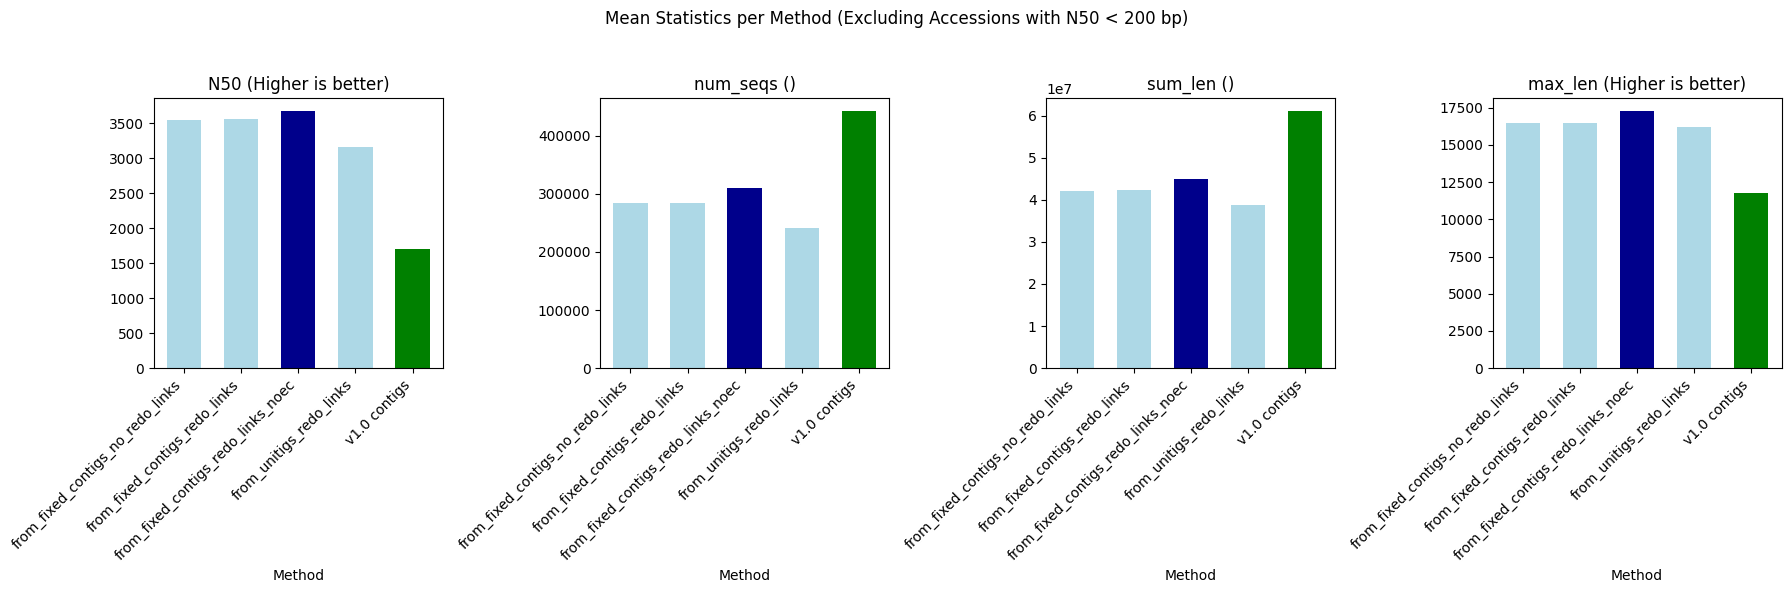

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the DataFrame is already loaded into variables
filtered_df['method'] = 'v1.0 contigs'
df_combined = pd.concat([df, filtered_df], ignore_index=True)

# Step 1: Filter out rows where N50 is less than 200
n50_filtered_df = df_combined[df_combined['N50'] >= 200]

# Step 2: Group by method and calculate the mean for all relevant stats
mean_stats_per_method = n50_filtered_df.groupby('method').mean().reset_index()

# Step 3: Define relevant statistics to plot and their corresponding labels
stats_to_plot = ['N50', 'num_seqs', 'sum_len', 'max_len']
optimization_labels = {
    'N50': 'Higher is better',
    'num_seqs': '',
    'sum_len': '',
    'max_len': 'Higher is better'
}

# Step 4: Create a horizontal layout for the subplots
num_stats = len(stats_to_plot)
fig, axes = plt.subplots(1, num_stats, figsize=(18, 6), sharey=False)

# Iterate through each statistic and create a plot
for i, stat in enumerate(stats_to_plot):
    ax = axes[i]
    # Highlight 'v1.0 contigs' in green and methods containing 'noec' in dark blue, others in light blue
    bar_colors = [
        'green' if method == 'v1.0 contigs' else 
        'darkblue' if 'noec' in method else 
        'lightblue' 
        for method in mean_stats_per_method['method']
    ]
    ax.bar(mean_stats_per_method['method'], mean_stats_per_method[stat], color=bar_colors, width=0.6)
    label = optimization_labels[stat]
    ax.set_title(f'{stat} ({label})')
    ax.set_xlabel('Method')
    ax.set_ylabel('')
    ax.set_xticks(range(len(mean_stats_per_method['method'])))
    ax.set_xticklabels(mean_stats_per_method['method'], rotation=45, ha='right')

# Adjust layout
fig.suptitle('Mean Statistics per Method (Excluding Accessions with N50 < 200 bp)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


     Accession         Scenario          Metric  Value
0  SRR11652706    minia_no_redo  bulges_removed     11
1  SRR11652706    minia_no_redo      ec_removed     32
2  SRR11652706    minia_no_redo    nt_assembled  11723
3  SRR11652706    minia_no_redo    tips_removed  51071
4  SRR11652706  minia_with_redo  bulges_removed     11


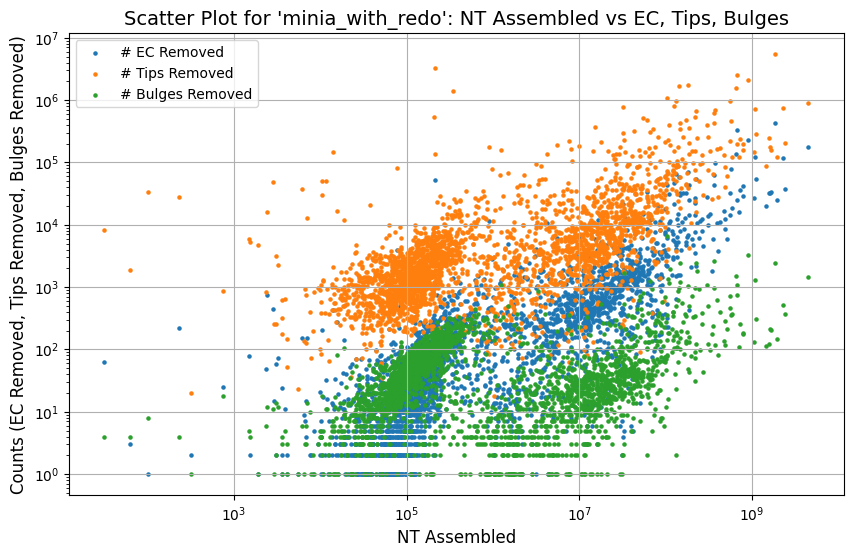

In [45]:
# now plot the ECs in relation to nt size
import pandas as pd

# Load and parse the file
def parse_ecstats_file(file_path):
    data = []
    accession = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line.startswith("Accession"):
                accession = line.split(":")[1].strip()
            elif line.endswith(":"):
                scenario = line[:-1].strip()
            elif ":" in line:
                key, value = line.split(":")
                data.append({
                    "Accession": accession,
                    "Scenario": scenario,
                    "Metric": key.strip(),
                    "Value": int(value.strip())
                })

    # Convert to a DataFrame
    return pd.DataFrame(data)

# Example usage
file_path = 'contigs_logs.parse.txt'  # Path to your file
data_df = parse_ecstats_file(file_path)

# Display the first few rows of the parsed data
print(data_df.head())


# Pivot the DataFrame for better analysis
pivot_df = data_df.pivot(index=["Accession", "Scenario"], columns="Metric", values="Value").reset_index()

# Filter for only "minia_with_redo"
filtered_df = pivot_df[pivot_df["Scenario"] == "minia_with_redo"]

# Remove rows with non-positive values for log scale
filtered_df = filtered_df[(filtered_df["nt_assembled"] > 0) & 
                          (filtered_df["ec_removed"] > 0) & 
                          (filtered_df["tips_removed"] > 0) & 
                          (filtered_df["bulges_removed"] > 0)]
# Plotting the data
plt.figure(figsize=(10, 6))

# Scatter plot for NT_assembled vs EC_removed
plt.scatter(filtered_df["nt_assembled"], filtered_df["ec_removed"], label="# EC Removed", s=5)

# Scatter plot for NT_assembled vs Tips_removed
plt.scatter(filtered_df["nt_assembled"], filtered_df["tips_removed"], label="# Tips Removed", s=5)

# Scatter plot for NT_assembled vs Bulges_removed
plt.scatter(filtered_df["nt_assembled"], filtered_df["bulges_removed"], label="# Bulges Removed", s=5)

# Adding labels and title
plt.xlabel("NT Assembled", fontsize=12)
plt.ylabel("Counts (EC Removed, Tips Removed, Bulges Removed)", fontsize=12)
plt.title("Scatter Plot for 'minia_with_redo': NT Assembled vs EC, Tips, Bulges", fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()